In [1]:
library(tidyverse)
library(gridExtra)
library(cowplot)

options(repr.plot.width=6, repr.plot.height=4)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [2]:
`%+replace%` <- ggplot2::`%+replace%`

theme_zietzm <- function(base_size = 11.5, base_family = "") {
    # Starts with theme_bw and then modify some parts
    # Theme options are documentated at http://docs.ggplot2.org/current/theme.html
    ggplot2::theme_classic(base_size = base_size, base_family = base_family) %+replace%
    ggplot2::theme(

        strip.background  = ggplot2::element_rect(fill = NA, colour = 'grey90', size = 0),
        strip.text = element_text(vjust = 1, size = 10),
        plot.margin       = ggplot2::margin(t=2, r=2, b=2, l=2, unit='pt'),
        legend.spacing     = grid::unit(0.1, 'cm'),
        legend.key        = ggplot2::element_blank(),
        panel.border=element_rect(fill = NA, color = 'black', size = 0.5), 
        axis.line=element_line(size=0),
    )
}

In [3]:
ppi_df <- read_tsv('../../data//2.edges//ppi.tsv.xz')
tftg_df <- read_tsv('../../data//2.edges//tftg.tsv.xz')

head(ppi_df, 2)

Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_double(),
  id_b = col_double(),
  train = col_double(),
  test_recon = col_double(),
  test_new = col_double()
)
Parsed with column specification:
cols(
  name_a = col_character(),
  name_b = col_character(),
  id_a = col_double(),
  id_b = col_double(),
  train = col_double(),
  test_recon = col_double(),
  test_new = col_double()
)


name_a,name_b,id_a,id_b,train,test_recon,test_new
A0A087WT00,O00154,0,48,1,1,0
A0A087WT00,O43736,0,237,0,1,0


In [4]:
format_degrees <- function(df) {
    df %>%
        group_by(id_a) %>%
        summarise(
            degree_a_train = sum(train),
            degree_a_test_recon = sum(test_recon),
            degree_a_test_new = sum(test_new)
        ) %>%
        full_join(
            df %>%
            group_by(id_b) %>%
            summarise(
                degree_b_train = sum(train),
                degree_b_test_recon = sum(test_recon),
                degree_b_test_new = sum(test_new)
            ),
            by = c("id_a" = "id_b")
        ) %>%
        replace(is.na(.), 0) %>%
        mutate(
            degree_train = degree_a_train + degree_b_train,
            degree_test_recon = degree_a_test_recon + degree_b_test_recon,
            degree_test_new = degree_a_test_new + degree_b_test_new
        ) %>%
        select(degree_train, degree_test_recon, degree_test_new)
}

In [5]:
ppi_degrees_df <- format_degrees(ppi_df)
tftg_degrees_df <- format_degrees(tftg_df)

In [6]:
df <- bind_rows(
    ppi_degrees_df %>% mutate(network = 'PPI'),
    tftg_degrees_df %>% mutate(network = 'TFTG')
)

reconstruction_df <- df %>%
    rename(x = degree_test_recon, y = degree_train) %>%
    select(x, y, network) %>%
    mutate(task = 'Reconstruction')
    

systematic_df <- df %>%
    rename(x = degree_test_new, y = degree_test_recon) %>%
    select(x, y, network) %>%
    mutate(task = 'Systematic')

vis_df <- bind_rows(reconstruction_df, systematic_df)

head(vis_df, 2)

x,y,network,task
75,55,PPI,Reconstruction
3,3,PPI,Reconstruction


In [7]:
facet_grid <- (
    ggplot(vis_df, aes(x = x, y = y))
    + geom_point()
    + geom_abline(slope = 1, intercept = 0, color = 'grey', linetype = 'dashed')
    + facet_grid(rows = vars(network), cols = vars(task), scales = 'free')
    + theme(
          axis.title.x = element_blank(),
          axis.title.y = element_blank()
    )
)

facet_wrap <- (
    ggplot(vis_df, aes(x = x, y = y))
    + geom_point()
    + geom_abline(slope = 1, intercept = 0, color = 'grey', linetype = 'dashed')
    + facet_wrap(vars(network, task), scales = 'free')
    + theme(
          axis.title.x = element_blank(),
          axis.title.y = element_blank()
    )
)

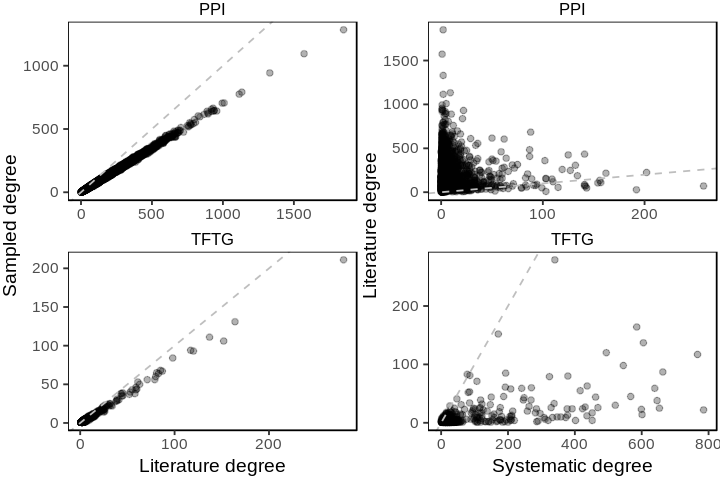

In [8]:
options(repr.plot.width=6, repr.plot.height=4)

reconstruction <- (
    ggplot(vis_df %>% filter(task == 'Reconstruction'), aes(x = x, y = y))
    + geom_point(alpha = 0.3)
    + geom_abline(slope = 1, intercept = 0, color = 'grey', linetype = 'dashed')
    + xlab('Literature degree')
    + ylab('Sampled degree')
    + facet_wrap('network', ncol = 1, scales = 'free')
    + theme_zietzm()
)

systematic <- (
    ggplot(vis_df %>% filter(task == 'Systematic'), aes(x = x, y = y))
    + geom_point(alpha = 0.3)
    + geom_abline(slope = 1, intercept = 0, color = 'grey', linetype = 'dashed')
    + xlab('Systematic degree')
    + ylab('Literature degree')
    + facet_wrap('network', ncol = 1, scales = 'free')
    + theme_zietzm()
)

g <- grid.arrange(reconstruction, systematic, ncol = 2)

ggsave('../../img/1_degree_bias/study_bias_points.png', plot = g, 
       width = 6, height = 4, dpi = 500)

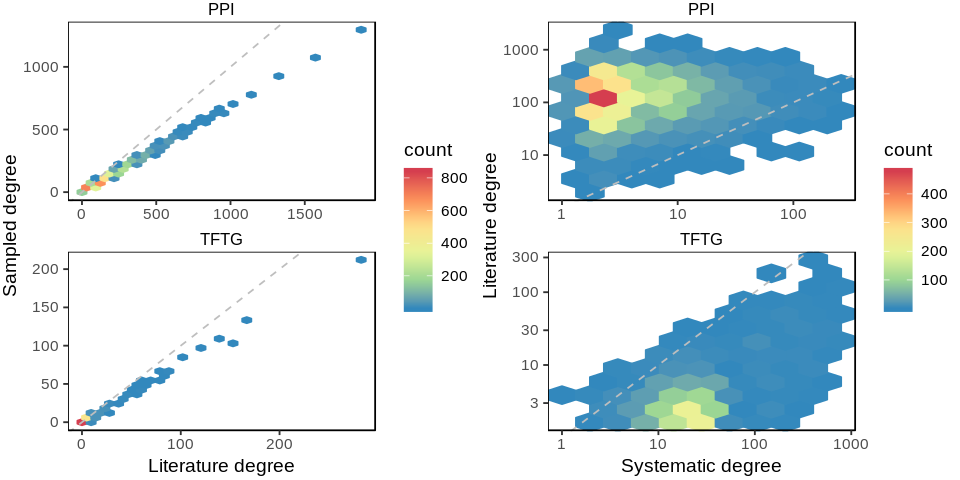

In [10]:
palette <- 'Spectral'
direction <- -1

options(repr.plot.width=8, repr.plot.height=4)

reconstruction <- (
    ggplot(vis_df %>% filter(task == 'Reconstruction'), aes(x = x + 1, y = y + 1))
    + stat_binhex(aes(color = ..count..))
    + geom_abline(slope = 1, intercept = 0, color = 'grey', linetype = 'dashed')
    + xlab('Literature degree')
    + ylab('Sampled degree')
    + facet_wrap('network', ncol = 1, scales = 'free')
    + theme_zietzm()
    + scale_fill_distiller(palette = palette, direction = direction)
    + scale_color_distiller(palette = palette, direction = direction)
)

systematic <- (
    ggplot(vis_df %>% filter(task == 'Systematic'), aes(x = x + 1, y = y + 1))
    + stat_binhex(aes(color = ..count..), bins = 10)
    + geom_abline(slope = 1, intercept = 0, color = 'grey', linetype = 'dashed')
    + xlab('Systematic degree')
    + ylab('Literature degree')
    + facet_wrap('network', ncol = 1, scales = 'free')
    + scale_x_log10()
    + scale_y_log10()
    + theme_zietzm()
    + scale_fill_distiller(palette = palette, direction = direction)
    + scale_color_distiller(palette = palette, direction = direction)
)

g <- grid.arrange(reconstruction, systematic, ncol = 2)

ggsave('../../img/1_degree_bias/study_bias_hexbin.png', plot = g, 
       width = 8, height = 4, dpi = 500)